# U-Net train
* 데이터셋은 ISBI 2012 EM Segmentation Challenge

In [84]:
# import
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff # TIF 파일 처리 라이브러리

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 데이터셋 불러오기

In [69]:
train_volume_path = "/content/train-volume.tif"
train_labels_path = "/content/train-labels.tif"
test_volume_path = "/content/test-volume.tif"

In [70]:
# TIF 파일 로드
train_images = tiff.imread(train_volume_path)  # (30, H, W) 형태의 학습 이미지 스택
train_masks = tiff.imread(train_labels_path)  # (30, H, W) 형태의 레이블 스택
test_images = tiff.imread(test_volume_path)    # (30, H, W) 형태의 테스트 이미지 스택

In [71]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train masks Shape: {train_masks.shape}")
print(f"Test Images Shape: {test_images.shape}")

Train Images Shape: (30, 512, 512)
Train masks Shape: (30, 512, 512)
Test Images Shape: (30, 512, 512)


# 데이터셋 시각화

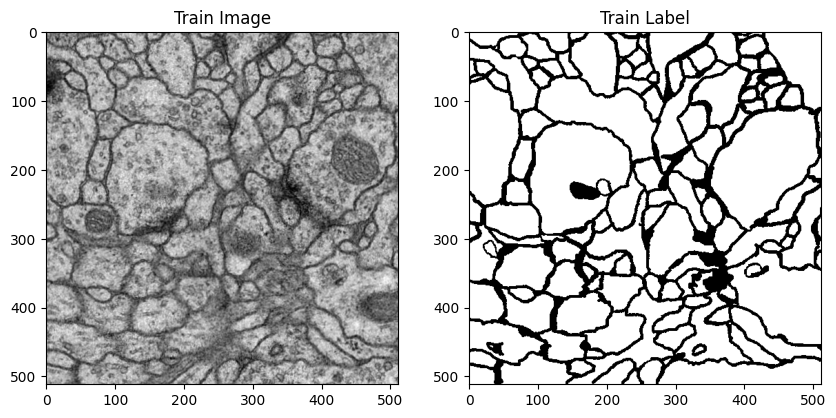

In [72]:
index = 0
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[index], cmap='gray')
plt.title("Train Image")
plt.subplot(1, 2, 2)
plt.imshow(train_masks[index], cmap='gray')
plt.title("Train Label")
plt.show()

# 데이터셋 클래스 정의

In [87]:
class ISBITIFFDataset(Dataset):
    def __init__(self, images, masks=None, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx] if self.masks is not None else None

        # NumPy 배열 → Tensor 변환 (채널 추가)
        image = torch.from_numpy(image).float().unsqueeze(0)  # (H, W) → (1, H, W)
        if mask is not None:
            mask = torch.from_numpy(mask).float().unsqueeze(0)  # (H, W) → (1, H, W)

        if self.transform:
            image = self.transform(image)
            if mask is not None:
                mask = self.transform(mask)

        return image, mask


# 데이터 로더 생성

In [80]:
transform = transforms.Compose([
    transforms.Resize((572, 572)),  # (572, 572)로 리사이즈
])

In [81]:
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
# 전체 데이터셋
full_dataset = ISBITIFFDataset(train_images, train_masks, transform=transform)

# 학습용 80%, 검증용 20% 비율로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 테스트 데이터셋
test_dataset = ISBITIFFDataset(test_images, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


# Model 정의 및 손실함수 옵티마이저 설정

In [76]:
import sys
sys.path.append('/content')

from U_Net import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss() # 이진 분류용 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:
# # Dice_score 는 Segmentation Task를 진행하면 흔하게 접하게 되는 개념
#  'Prediction과 Ground-Truth가 얼마나 겹치느냐'를 평가하는 데에 쓰인다.
# Dice Score가 1에 가까울 수록 모델의 민감도와 정밀도가 좋다는 뜻이고,
#반대로 0에 가까울 수록 민감도 또는 정밀도(둘 중 무엇인지는 실제로 값을 뽑아봐야 알 수 있음)가 안 좋다는 뜻이다.
def dice_score(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()  # 예측 값을 0 또는 1로 이진화
    intersection = (pred * target).sum()  # 교집합
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-6)  # Dice Score 계산

# 학습 루프

In [90]:
import torchvision.transforms.functional as TF

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    dice_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # 모델 예측
            outputs = model(images)

            # 레이블 크기 맞추기 (center_crop 적용)
            masks = TF.center_crop(masks, [outputs.shape[2], outputs.shape[3]])

            # 손실 계산 및 역전파
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        dice_total = 0.0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)

                # 레이블 크기 맞추기
                val_masks = TF.center_crop(val_masks, [val_outputs.shape[2], val_outputs.shape[3]])

                # 손실 및 Dice Score 계산
                val_loss += criterion(val_outputs, val_masks).item()
                dice_total += dice_score(val_outputs, val_masks).item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_dice = dice_total / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        dice_scores.append(avg_dice)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice Score: {avg_dice:.4f}")

    return train_losses, val_losses, dice_scores


In [91]:
# 학습 설정
num_epochs = 50
train_losses, val_losses, dice_scores = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

KeyboardInterrupt: 